In [24]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples
from scipy.spatial.distance import cosine
from scipy.cluster.vq import kmeans, vq

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras_self_attention import SeqSelfAttention

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout, Lambda, Multiply, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7121266401539491667
xla_global_id: -1
]


In [26]:
# Create relative path method to access all the files in data/raw/train folder
def relative_path(path):
    return os.path.join(os.getcwd(), path)

In [27]:
def evaluate(final_df, stream,final_predictions):
    # Calculate F1 Score
    f1 = f1_score(final_df['actual_anomaly'], final_df['predicted_labels'])
    print(f"F1 Score: {f1}")
    # True Positives
    tp_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 1)
    # True Negatives
    tn_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 0)
    # False Positives
    fp_filter = (final_df['actual_anomaly'] == 0) & (final_df['predicted_labels'] == 1)
    # False Negatives
    fn_filter = (final_df['actual_anomaly'] == 1) & (final_df['predicted_labels'] == 0)
    # Precision
    precision = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fp_filter]))
    # Recall
    recall = len(final_df[tp_filter]) / (len(final_df[tp_filter]) + len(final_df[fn_filter]))
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f'False Negatives: {len(final_df[fn_filter])}')
    print(f'False Positives: {len(final_df[fp_filter])}')
    print(f'True Negatives: {len(final_df[tn_filter])}')
    print(f'True Positives: {len(final_df[tp_filter])}')
    
    # Add evaluation Metrics to .csv file for on sample where chan_id == stream
    final_predictions.loc[final_predictions['chan_id'] == stream, 'f1'] = f1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'precision'] = precision
    final_predictions.loc[final_predictions['chan_id'] == stream, 'recall'] = recall
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tp'] = len(final_df[tp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'tn'] = len(final_df[tn_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fp'] = len(final_df[fp_filter])
    final_predictions.loc[final_predictions['chan_id'] == stream, 'fn'] = len(final_df[fn_filter])
    
    # calculate range or sequence of anomalies predicted
    predicted_anomalies = []
    start = 0
    end = 0
    while end < len(final_df):
        slice = final_df.iloc[start:end+1]
        if not slice.empty:
            if slice['predicted_labels'].iloc[0] == 1:
                if start == 0:
                    start = end
            else:
                if start != 0:
                    end = end - 1
                    predicted_anomalies.append([start,end])
                    start = 0
        if end < len(final_df):
            end += 1
    final_predictions.loc[final_predictions['chan_id'] == stream, 'predicted_anomalies'] = str(predicted_anomalies)
    return final_predictions

In [28]:
def train_autoencoder(train_df, test_df):
    # Split the data into train and test sets
    # X_train, X_test = train_test_split(train_df.values, test_size=0.2, random_state=42)
    
    # Define the dimensions of the latent space
    latent_dim = 8
    input_dim = train_df.shape[1]
    
    # Create an autoencoder model with dropout layers
    # Do not use dropouts.  For some reason we can't build clusters when using dropout
    
    input_layer = keras.Input(shape=(train_df.shape[1],))
    encoded = layers.Dense(32, activation='tanh', activity_regularizer=regularizers.l1(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = layers.Dense(16, activation='tanh', activity_regularizer=regularizers.l1(0.001))(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Latent layer with attention
    latent_layer = Dense(latent_dim, activation='tanh', activity_regularizer=regularizers.l1(0.001))(encoded)   

    # Decoder
    decoded = layers.Dense(16, activation='tanh', activity_regularizer=regularizers.l1(0.001))(latent_layer)
    decoded = Dropout(0.2)(decoded)
    decoded = layers.Dense(32, activation='tanh', activity_regularizer=regularizers.l1(0.001))(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = layers.Dense(input_dim, activation='tanh')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    # Compile the autoencoder with gradient clipping
    optimizer = Adam(clipnorm=1.0)  # Clip gradients by their norm
    autoencoder.compile(optimizer=optimizer, loss='mse')

    # Define Early Stopping and Reduce Learning Rate callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=15, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    # Train the autoencoder with callbacks
    history = autoencoder.fit(
        train_df, train_df,
        epochs=300,
        batch_size=32,
        shuffle=False,
        callbacks=[early_stopping, reduce_lr]  # Pass the callbacks
    )
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    encoder = keras.Model(input_layer, latent_layer)
    # Encode entire dataset
    test_latent_representation = encoder.predict(test_df.values)
    train_latent_representation = encoder.predict(train_df.values)
    return test_latent_representation, train_latent_representation, autoencoder

In [34]:
def lstm_model(train_latent_representation, test_latent_representation):
    X_train_seq, y_train_seq = sequence_data(train_latent_representation)
    X_test_seq, y_test_seq = sequence_data(test_latent_representation)

    model = Sequential([
        LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(y_train_seq.shape[1] * y_train_seq.shape[2]),  # Adjusting the Dense layer
        Reshape((y_train_seq.shape[1], y_train_seq.shape[2])) # Adding a Reshape layer
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32)
    predictions = model.predict(X_test_seq)

    # Mean squared error for each prediction
    def calculate_error(y_true, y_pred):
        return np.mean(np.square(y_true - y_pred), axis=1)
    
    # Calculating errors for each sample in the test set
    errors = np.array([calculate_error(y_test_seq[i], predictions[i]) for i in range(len(y_test_seq))])

    # Now, errors is a 2D array with shape (number of sequences, number of timesteps)
    # We take the mean across the timestep axis to get a single error value per sequence
    mean_errors = np.mean(errors, axis=1)

    return mean_errors

In [29]:
def get_reconstruction_loss(autoencoder, test_df,final_df):
    max_window_size = 100
    recon_losses = []
    start = 0
    end = 0

    while end < len(test_df):
        slice = test_df.iloc[start:end+1]
        print(f"Processing slice: Start = {start}, End = {end}, Shape = {slice.shape}")

        # Check if the slice is empty
        if not slice.empty:
            # Reconstruct slice
            recon = autoencoder.predict(slice.values)
            print(f"Reconstructed shape: {recon.shape}")

            # Calculate recon loss for the entire slice
            loss = np.mean(np.square(slice.values - recon), axis=1)
            mean_loss = np.mean(loss)
            recon_losses.append(mean_loss)

        # Increment the start by 1 if the end is greater than or equal to the max window size
        if end >= max_window_size:
            start += 1

        # Check if end has reached the end of the DataFrame
        if end < len(test_df):
            end += 1
    final_df['recon_losses'] = recon_losses
    return final_df

In [30]:
def perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, k_values, final_df, max_iter=400, random_state=42):
    """
    Perform K-Means clustering with iterative refinement based on silhouette score.

    Parameters:
    - X: Input data (features) as a DataFrame or numpy array.
    - k_values: List of K values to consider.
    - n_init: Number of times the K-Means algorithm will be run with different centroid seeds.
    - max_iter: Maximum number of iterations for each run of the K-Means algorithm.
    - random_state: Seed for randomization (optional).

    Returns:
    - Tuple containing (best_K, best_score, cluster_labels).
    """
    
    if isinstance(test_latent_representation, pd.DataFrame):
        test_latent_representation = test_latent_representation.values  # if dataframe Convert DataFrame to numpy array

    if isinstance(train_latent_representation, pd.DataFrame):
        train_latent_representation = train_latent_representation.values  # if dataframe Convert DataFrame to numpy array
    
    # scaler = StandardScaler()
    # train_latent_representation = scaler.fit_transform(train_latent_representation)
    # test_latent_representation = scaler.transform(test_latent_representation)
    
    best_k = None
    best_silhouette_score = -1

    for k in k_values:
        print(f"Current k value: {k}")
        kmeans = KMeans(n_clusters=k, n_init=20, init='k-means++', max_iter=max_iter, random_state=random_state).fit(train_latent_representation)
        labels = kmeans.predict(train_latent_representation)

        # Calculate the silhouette score
        silhouette_values = silhouette_samples(train_latent_representation, labels, metric='euclidean')

        # Calculate the weighted average of the silhouette coefficients
        silhouette_avg = np.mean(silhouette_values)
        print(f"Silhouette score: {silhouette_avg}")

        # Check if this is the best silhouette score so far
        if silhouette_avg > best_silhouette_score:
            best_k = k
            best_silhouette_score = silhouette_avg

    
    print(f"Best K: {best_k}")
    print(f"Best Silhouette Score: {best_silhouette_score}")
    
    kmeans = KMeans(n_clusters=best_k, n_init=20, init='k-means++',max_iter=max_iter,random_state=random_state).fit(train_latent_representation)

    # Predicting the cluster labels for the test set
    cluster_labels = kmeans.predict(test_latent_representation)

    # Computing the distances of samples in test set to all cluster centers
    distances = kmeans.transform(test_latent_representation)

    # Extracting the distances of each sample to its assigned cluster
    distances_to_assigned_cluster = distances[np.arange(len(distances)), cluster_labels]
    cluster_centers = kmeans.cluster_centers_
    # Graph Cluster_centers
    plt.figure(figsize=(10, 6))
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='r')
    plt.title('Cluster Centers')
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.show()
    final_df['anomaly_score'] = distances_to_assigned_cluster
    return final_df

In [31]:
def perform_thresholding(final_df):
    X = final_df[['anomaly_score', 'recon_losses','lstm_error']].values
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    print('Here is the dataframe of combined anomaly scores')
    print(pd.DataFrame(X,columns=['kmeans anomaly score', 'recon losses','lstm error']))
    nbrs = NearestNeighbors(n_neighbors=7000)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)

    threshold = np.mean(distances)

    predicted_labels = np.where(distances.mean(axis=1) > threshold, 1, 0)
    final_df['predicted_labels'] = predicted_labels
    
    return final_df


In [32]:
def distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream):
    # Extract the anomaly sequences for the given stream
    anomaly_sequences = labeled_anomalies[labeled_anomalies['chan_id'] == stream]['anomaly_sequences'].tolist()

    # Convert the string representation of list to actual list
    actual_anomalies = [eval(seq) for seq in anomaly_sequences]

    # Get the number of values for the given stream
    num_values = labeled_anomalies.loc[labeled_anomalies['chan_id'] == stream, 'num_values'].values[0]

    # Initialize a binary array with zeros of length num_values
    binary_labels = np.zeros(num_values)

    # Iterate through all sequences and mark the anomalies
    for anomaly in actual_anomalies:
        for start, end in anomaly:  # Assuming anomaly is a list of [start, end] lists
            binary_labels[start:end + 1] = 1

    # Create a DataFrame from the binary_labels array
    binary_frame = pd.DataFrame(binary_labels, columns=['actual_anomaly'])

    # Concatenate the new binary_frame with the final_df
    final_df = pd.concat([final_df.reset_index(drop=True), binary_frame.reset_index(drop=True)], axis=1)

    return final_df

In [33]:
def sequence_data(train_latent_representation):
    input_seq_len = 100
    output_seq_length = 10
    X_seq, y_seq = [], []
    for i in range(len(train_latent_representation) - input_seq_len - output_seq_length):
        X_seq.append(train_latent_representation[i:i + input_seq_len]) 
        y_seq.append(train_latent_representation[i + input_seq_len:i + input_seq_len + output_seq_length])

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    return X_seq, y_seq

Currently working on D-1 Channel
Epoch 1/300
90/90 [==============================] - 2s 2ms/step - loss: 0.1967 - lr: 0.0010
Epoch 2/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0900 - lr: 0.0010
Epoch 3/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0761 - lr: 0.0010
Epoch 4/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0678 - lr: 0.0010
Epoch 5/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0627 - lr: 0.0010
Epoch 6/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0591 - lr: 0.0010
Epoch 7/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0563 - lr: 0.0010
Epoch 8/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0543 - lr: 0.0010
Epoch 9/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0527 - lr: 0.0010
Epoch 10/300
90/90 [==============================] - 0s 2ms/step - loss: 0.0508 - lr: 0.0010
Epoch 11/300
90/90 [================

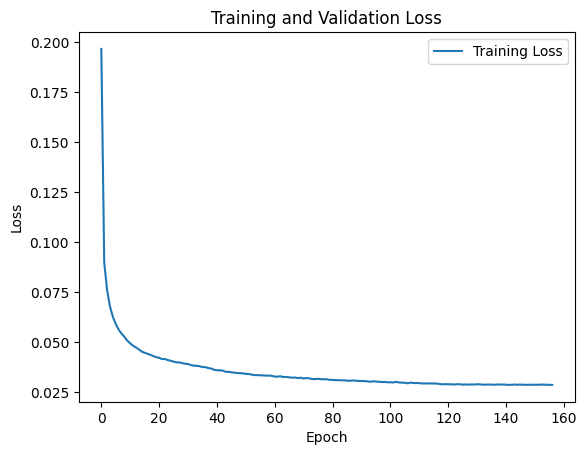

90/90 [==============================] - 0s 1ms/step
Current k value: 3
Silhouette score: 0.8874657154083252
Current k value: 4
Silhouette score: 0.8910053968429565
Current k value: 5
Silhouette score: 0.9192648530006409
Current k value: 6
Silhouette score: 0.9341847896575928
Current k value: 7
Silhouette score: 0.9455106258392334
Current k value: 8
Silhouette score: 0.9507154822349548
Current k value: 9
Silhouette score: 0.9544914960861206
Current k value: 10
Silhouette score: 0.9591407775878906
Current k value: 11
Silhouette score: 0.9697467088699341
Current k value: 12
Silhouette score: 0.9732951521873474
Current k value: 13
Silhouette score: 0.9842545390129089
Current k value: 14
Silhouette score: 0.9878332614898682
Current k value: 15
Silhouette score: 0.9909896850585938
Current k value: 16
Silhouette score: 0.9919933080673218
Current k value: 17
Silhouette score: 0.9926284551620483
Current k value: 18
Silhouette score: 0.9927719235420227
Current k value: 19
Silhouette score: 0.99

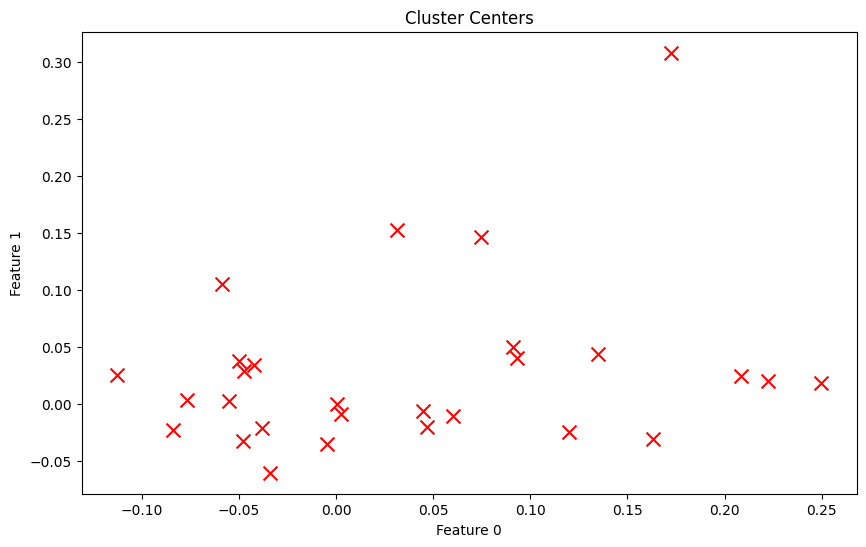

Processing slice: Start = 0, End = 0, Shape = (1, 25)
1/1 [==============================] - 0s 102ms/step
Reconstructed shape: (1, 25)
Processing slice: Start = 0, End = 1, Shape = (2, 25)
1/1 [==============================] - 0s 24ms/step
Reconstructed shape: (2, 25)
Processing slice: Start = 0, End = 2, Shape = (3, 25)
1/1 [==============================] - 0s 24ms/step
Reconstructed shape: (3, 25)
Processing slice: Start = 0, End = 3, Shape = (4, 25)
1/1 [==============================] - 0s 33ms/step
Reconstructed shape: (4, 25)
Processing slice: Start = 0, End = 4, Shape = (5, 25)
1/1 [==============================] - 0s 24ms/step
Reconstructed shape: (5, 25)
Processing slice: Start = 0, End = 5, Shape = (6, 25)
1/1 [==============================] - 0s 24ms/step
Reconstructed shape: (6, 25)
Processing slice: Start = 0, End = 6, Shape = (7, 25)
1/1 [==============================] - 0s 16ms/step
Reconstructed shape: (7, 25)
Processing slice: Start = 0, End = 7, Shape = (8, 25)


In [35]:
parent_dir = os.path.dirname(os.getcwd())
channels_folder = os.path.join(parent_dir, 'data','raw','train')
channels = os.listdir(channels_folder)

labeled_anomalies_file = os.path.join(parent_dir, 'data','processed','labeled_anomalies.csv')
labeled_anomalies = pd.read_csv(labeled_anomalies_file)
channel = 'D-1.npy'

final_predictions = labeled_anomalies.copy()
# Add a columns for f1 score, precision, recall, tp, tn, fp, fn to final predictions dataframe
final_predictions['f1'] = 0
final_predictions['precision'] = 0
final_predictions['recall'] = 0
final_predictions['tp'] = 0
final_predictions['tn'] = 0
final_predictions['fp'] = 0
final_predictions['fn'] = 0
final_predictions['predicted_anomaly_sequences'] = 0
stream = channel[:-4]
final_df = pd.DataFrame()    
print(f'Currently working on {stream} Channel')

train_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','train',f'{channel}')))
test_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','test',f'{channel}')))

test_latent_representation, train_latent_representation, autoencoder = train_autoencoder(train_df, test_df)

# Perform K-Means clustering with iterative refinement based on silhouette score\
final_df  = perform_kmeans_with_refinement(test_latent_representation, train_latent_representation, range(3,60), final_df)
# Perform Sliding Window Autoencoder to get reconstruction loss
final_df  = get_reconstruction_loss(autoencoder, test_df,final_df)


In [36]:

# Get LSTM predictions
errors = lstm_model(train_latent_representation,test_latent_representation)

Epoch 1/20
86/86 [==============================] - 11s 94ms/step - loss: 0.0011
Epoch 2/20
86/86 [==============================] - 10s 122ms/step - loss: 9.9124e-04
Epoch 3/20
86/86 [==============================] - 9s 100ms/step - loss: 9.7324e-04
Epoch 4/20
86/86 [==============================] - 9s 100ms/step - loss: 9.6245e-04
Epoch 5/20
86/86 [==============================] - 8s 96ms/step - loss: 9.5562e-04
Epoch 6/20
86/86 [==============================] - 8s 95ms/step - loss: 9.4941e-04
Epoch 7/20
86/86 [==============================] - 9s 99ms/step - loss: 9.4099e-04
Epoch 8/20
86/86 [==============================] - 8s 95ms/step - loss: 9.3130e-04
Epoch 9/20
86/86 [==============================] - 10s 113ms/step - loss: 9.2400e-04
Epoch 10/20
86/86 [==============================] - 10s 114ms/step - loss: 9.1862e-04
Epoch 11/20
86/86 [==============================] - 11s 125ms/step - loss: 9.1729e-04
Epoch 12/20
86/86 [==============================] - 10s 114ms/step

In [37]:
# Concatenate errors to final_df, length's don't match so add 0's to beginning of errors to help concatenate.  The amount of zeros to add should be len(final_df) - len(errors)
zeros = np.zeros(len(final_df) - len(errors))
errors = np.concatenate((zeros,errors), axis=0)
final_df['lstm_error'] = errors

In [38]:
final_df   =  distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream)


In [39]:
scaler = MinMaxScaler()
final_df = pd.DataFrame(scaler.fit_transform(final_df), columns=final_df.columns)

In [40]:
final_df

,anomaly_score,recon_losses,lstm_error,actual_anomaly
0,0.000538,0.454050,0.000000,0.0
1,0.000538,0.454050,0.000000,0.0
2,0.000538,0.454050,0.000000,0.0
3,0.000538,0.454050,0.000000,0.0
4,0.000538,0.454050,0.000000,0.0
...,...,...,...,...
8504,0.007083,0.282326,0.001360,1.0
8505,0.007083,0.282326,0.001363,1.0
8506,0.007083,0.282326,0.001365,1.0
8507,0.007083,0.282326,0.001367,1.0


In [49]:
import plotly.graph_objects as go

# Example data
x = final_df['anomaly_score']
y = final_df['recon_losses']
z = final_df['lstm_error']
color = final_df['actual_anomaly']  # Assuming this is categorical

# Define your mapping
legend_mapping = {0.0: 'Normal', 1.0: 'Anomaly'}

# Create a 3D scatter plot with separate traces for each category in 'color'
fig = go.Figure()
for category in color.unique():
    fig.add_trace(go.Scatter3d(
        x=x[color == category],
        y=y[color == category],
        z=z[color == category],
        mode='markers',
        name=legend_mapping.get(category, str(category)),  # Use the mapping for the trace name
        marker=dict(
            size=6,
            color=category,
            colorscale='Viridis',
            opacity=0.8
        )
    ))

# Set the title and labels
fig.update_layout(scene=dict(
                    xaxis_title='Kmeans Anomaly Score',
                    yaxis_title='Recon Losses',
                    zaxis_title='LSTM Error'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10),
                  legend_title="Legend Title")

# Display the plot
fig.show()


In [42]:
final_df   =  perform_thresholding(final_df)
print('---'*10)
print('Here are the final evaluation results')
final_predictions = evaluate(final_df, stream, final_predictions)

Here is the dataframe of combined anomaly scores
      kmeans anomaly score  recon losses  lstm error
0                 0.000538      0.454050    0.000000
1                 0.000538      0.454050    0.000000
2                 0.000538      0.454050    0.000000
3                 0.000538      0.454050    0.000000
4                 0.000538      0.454050    0.000000
...                    ...           ...         ...
8504              0.007083      0.282326    0.001360
8505              0.007083      0.282326    0.001363
8506              0.007083      0.282326    0.001365
8507              0.007083      0.282326    0.001367
8508              0.007083      0.282326    0.001370

[8509 rows x 3 columns]
------------------------------
Here are the final evaluation results
F1 Score: 0.9339509862522416
Precision: 0.9102825517040489
Recall: 0.9588830929733047
False Negatives: 134
False Positives: 308
True Negatives: 4942
True Positives: 3125


C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_2620\1647934281.py:25: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9339509862522416' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_2620\1647934281.py:26: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9102825517040489' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_2620\1647934281.py:27: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9588830929733047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\AXW0J9E\AppData\Local\Temp\ipykernel_2620\1647934281.py:50: FutureWarning:

Setting an item of incompat

In [43]:
final_predictions

,chan_id,spacecraft,anomaly_sequences,class,num_values,f1,precision,recall,tp,tn,fp,fn,predicted_anomaly_sequences,predicted_anomalies
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505,0.0,0.0,0.0,0,0,0,0,0,NaN
1,S-1,SMAP,"[[5300, 5747]]",[point],7331,0.0,0.0,0.0,0,0,0,0,0,NaN
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516,0.0,0.0,0.0,0,0,0,0,0,NaN
3,E-2,SMAP,"[[5598, 6995]]",[point],8532,0.0,0.0,0.0,0,0,0,0,0,NaN
4,E-3,SMAP,"[[5094, 8306]]",[point],8307,0.0,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,P-11,MSL,"[[1778, 1898], [1238, 1344]]","[point, point]",3535,0.0,0.0,0.0,0,0,0,0,0,NaN
78,D-15,MSL,"[[1500, 2140]]",[point],2158,0.0,0.0,0.0,0,0,0,0,0,NaN
79,D-16,MSL,"[[600, 1250]]",[contextual],2191,0.0,0.0,0.0,0,0,0,0,0,NaN
80,M-7,MSL,"[[940, 1040]]",[point],2156,0.0,0.0,0.0,0,0,0,0,0,NaN


In [44]:
telemetry = pd.DataFrame(test_df[0])
telemetry.columns = ['telemetry']
telemetry

,telemetry
0,-0.684211
1,-0.684211
2,-0.684211
3,-0.684211
4,-0.684211
...,...
8504,0.578947
8505,0.578947
8506,0.578947
8507,0.578947


In [45]:
final_frame = pd.concat([final_df, telemetry], axis=1)
final_frame

,anomaly_score,recon_losses,lstm_error,actual_anomaly,predicted_labels,telemetry
0,0.000538,0.454050,0.000000,0.0,0,-0.684211
1,0.000538,0.454050,0.000000,0.0,0,-0.684211
2,0.000538,0.454050,0.000000,0.0,0,-0.684211
3,0.000538,0.454050,0.000000,0.0,0,-0.684211
4,0.000538,0.454050,0.000000,0.0,0,-0.684211
...,...,...,...,...,...,...
8504,0.007083,0.282326,0.001360,1.0,1,0.578947
8505,0.007083,0.282326,0.001363,1.0,1,0.578947
8506,0.007083,0.282326,0.001365,1.0,1,0.578947
8507,0.007083,0.282326,0.001367,1.0,1,0.578947


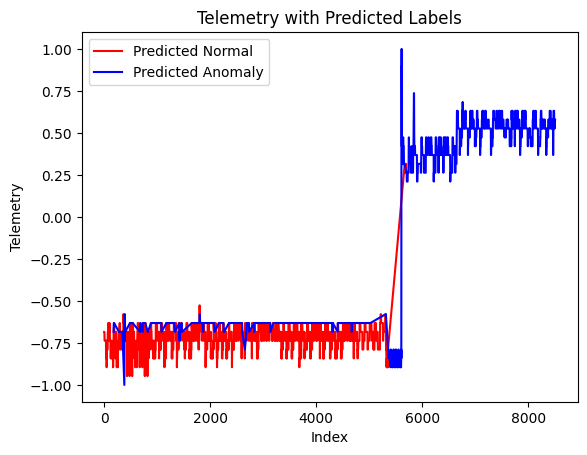

In [46]:
import matplotlib.pyplot as plt

# Sort the DataFrame by index
data = final_frame.sort_index()

# Split the data into two DataFrames based on the predicted_labels
data_red = data[data['predicted_labels'] == 0]
data_blue = data[data['predicted_labels'] == 1]

# Plot the red segments
plt.plot(data_red.index, data_red['telemetry'], 'r', label='Predicted Normal')

# Plot the blue segments
plt.plot(data_blue.index, data_blue['telemetry'], 'b', label='Predicted Anomaly')

# Add a title and labels to the plot
plt.title('Telemetry with Predicted Labels')
plt.xlabel('Index')
plt.ylabel('Telemetry')

# Display the legend
plt.legend()

# Display the plot
plt.show()

